```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Data Mining

## Table of Contents

- [Introduction & Problems in Data Mining](#intro)



In [ ]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# To eliminate Yellowbrick warming: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
import matplotlib.font_manager

import seaborn as sns

In [4]:
#pd.show_versions()

In [5]:
from sklearn import (
    model_selection,
    preprocessing,
)

In [6]:
df = get_dataset('random')
df.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101
0,-0.635418,-0.579130,-0.676321,-0.604970,-0.625573,-0.076850,-0.117557,0.052531,-2.148799,-0.708732,...,-0.340362,0.454675,0.680194,-0.853380,-0.519645,0.325074,-0.398741,-0.865025,0.987153,2.083426
1,0.789120,-0.029943,-0.030433,1.015895,0.402405,-0.967939,-0.416510,0.046567,0.103896,-0.218818,...,0.636485,0.562326,0.127324,-1.577315,-0.930546,-0.901475,-0.763227,-0.703632,0.637635,0.384451
2,1.605939,1.049132,0.162055,-0.516985,0.109957,0.458772,-0.531809,2.613801,-1.506208,0.184250,...,0.155942,-0.908405,0.955394,0.780379,-0.656410,-0.047792,0.088879,-0.465415,1.063126,0.900271
3,0.339110,1.150962,1.701447,-0.129415,1.278501,-0.960337,-0.075751,-0.864351,-1.610699,-1.797953,...,1.039415,0.018883,0.476241,1.050285,0.589970,-1.162643,0.172146,0.357803,1.946083,-1.153739
4,0.422166,-0.557173,-0.669985,-0.148770,-0.791304,0.318879,-0.946038,0.002033,-1.048584,-0.956571,...,0.227441,-1.820885,-1.356901,-1.550917,-0.298832,0.694426,0.293901,0.494673,1.134619,1.084429


In [7]:
df.shape

(30, 101)

In [8]:
# Missing values?
df.isnull().mean().value_counts()

0.0    101
dtype: int64

In [9]:
y = df[['C1']]
X = df.drop(columns=['C1'])

In [10]:
y[:5]

,C1
0,-0.635418
1,0.789120
2,1.605939
3,0.339110
4,0.422166


---
<a id='intro'></a>

## Introduction

`Data mining` is the process of exploring a data set and allowing the patterns in the sample to suggest the correct model rather than being guided by theory. This process is easy because you can quickly test numerous combinations of independent variables to uncover statistically significant relationships. In fact, automated model building procedures, such as stepwise and best subsets regression, can fit thousands of models quickly. You can continue adding statistically significant variables as you find them, and R-squared always increases.

Over the years, I’ve heard numerous comments about how it makes sense to look at many different variables, their interactions, and polynomials in all sorts of combinations. After all, if you end up with a model that is full of statistically significant variables, a high R-squared, and good looking residual plots, what can possibly be wrong? That’s exactly what I’m going to show you!

### Regression Example that Illustrates the Problems of Data Mining
The first thing I want to show is the severity of the problems. That way, if you use this approach, you understand the potential problems. Luckily, it’s easy to demonstrate because data mining can find statistically significant correlations in data that are randomly generated. `Data mining can take a set of randomly generated independent variables and use them to explain the majority of the variation in a randomly generated dependent variable`.

For this demonstration, I’ve created 101 columns of data, and each one contains 30 rows of entirely random data. The first column (C1) will be the dependent variable, and the other 100 columns are potential independent variables. I’ll use stepwise regression to pick the model.

This scenario forces the procedure to dredge through 100 models just to pick the first variable, and then repeat that for the next variables. That’s a lot of models to fit! We’ll talk more about that later because it’s a defining characteristic of data mining.

### Using Stepwise Regression on Random Data
In simple terms, `stepwise regression` is a process that helps determine which factors are important and which are not. Certain variables have a rather high p-value and were not meaningfully contributing to the accuracy of our prediction. From there, only important factors are kept to ensure that the linear model does its prediction based on factors that can help it produce the most accurate result.

### Forward Selection with statsmodels
Python's statsmodels doesn't have a built-in method for choosing a linear model by forward selection. It tries to optimize adjusted R-squared by adding features that help the most one at a time until the score goes down or you run out of features.

In [11]:
# https://planspace.org/20150423-forward_selection_with_statsmodels/

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    
    while remaining and current_score <= best_new_score:
        
        scores_with_candidates = []
        
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    
    return model

In [12]:
model = forward_selected(df, 'C1')

print(model.model.formula)
print(model.rsquared_adj)

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


C1 ~ C35 + C28 + C87 + C81 + C45 + C90 + C57 + C99 + C26 + C66 + C84 + C7 + C58 + C59 + C51 + C65 + C92 + C41 + C83 + C61 + C64 + C20 + C70 + C76 + C63 + C33 + C67 + C16 + 1
0.9999999999773144


Initially, the stepwise procedure adds 28 independent variables to the model, which explains 100% of the variance! Because we have a sample size of only 30, we’re obviously overfitting the model. Overfitting a model is a different issue that also inflates R-squared.

I want to address only the problems related to data mining, so I’ll reduce the number of independent variables to avoid an overfit model. A good rule of thumb is to include a maximum of one variable for every 10 observations. With 30 observations, I’ll include only the first three variables that stepwise regression picks: C35, C28, and C87. The stepwise regression output for the first three variables is below.

In [13]:
X = df[['C35', 'C28', 'C87']]

In [14]:
import statsmodels.api as sm

model = sm.OLS(y, X)
results = model.fit(method='qr')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     C1   R-squared (uncentered):                   0.427
Model:                            OLS   Adj. R-squared (uncentered):              0.364
Method:                 Least Squares   F-statistic:                              6.719
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                     0.00156
Time:                        17:21:59   Log-Likelihood:                         -33.553
No. Observations:                  30   AIC:                                      73.11
Df Residuals:                      27   BIC:                                      77.31
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The coefficient P value for C35 is statistically significant. The R-squared of 42%% can be considered moderate depending on the field of study. However, for random data, it’s unbelievable—literally! In actual research, you’re likely to have some real effects mixed in, which can produce an even higher R-squared. The residual plots look good.

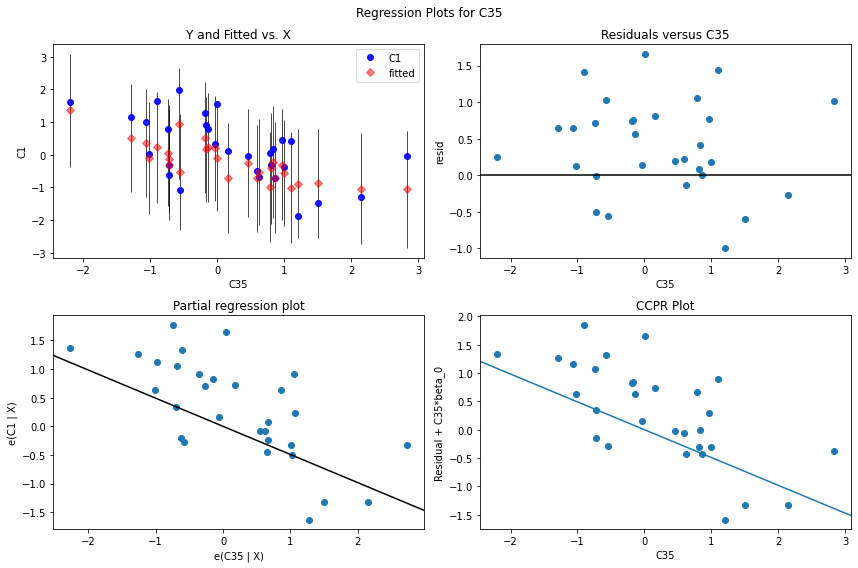

In [15]:
plt.rc("figure", figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(results, "C35")
fig.tight_layout(pad=1.0)

Just to be sure, let’s graph the relationship between an independent variable (C35) and the dependent variable (C1). We’ll see if it looks like a real relationship. Seeing is believing!

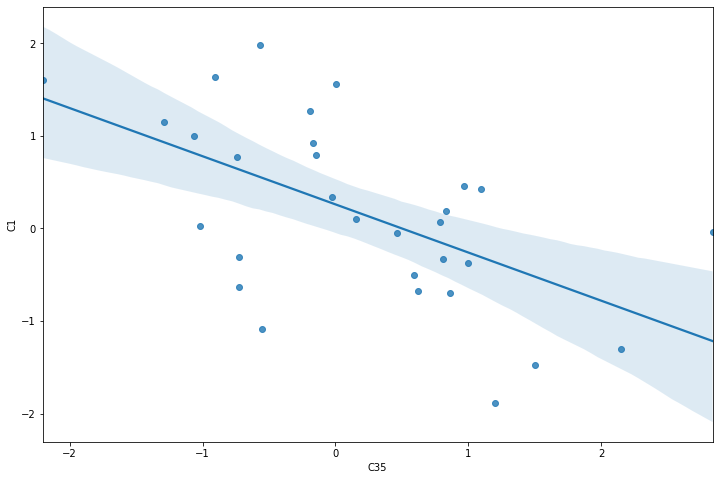

In [16]:
sns.regplot(x="C35", y="C1", data=df[['C1', 'C35', 'C28', 'C87']]);

This plot looks good. The graph shows that as C35 increases, the dependent variable (C1) tends to decrease, which is consistent with the negative coefficient in the output. The data sure look like they follow a real relationship. If we didn’t know that the data are random, we’d think it’s a great model!

### Lessons Learned from the Data Mining Example
The example above shows how data mining symptoms can be hard to detect. There are no visible signs of problems even though all of the results are deceptive. The statistical output and chart look great. Unfortunately, these results don’t reflect actual relationships but instead represent chance correlations that are guaranteed to occur with enough opportunities.

In the introduction, I asked, “What can possibly be wrong?” Now you know—everything can be wrong! The regression model suggests that random data can explain other random data, which is impossible. If you didn’t already know that there are no actual relationships between these variables, these results would lead you to completely inaccurate conclusions. Additionally, the capability of this model to predict new observations is zero despite the predicted R-squared.

The problems are real. Now, let’s move on to explaining how they happen and how to avoid them.

### How Data Mining Causes these Problems
For all hypothesis tests, including tests for regression coefficients, there is always the chance of rejecting a null hypothesis that is actually true (Type I error). This error rate equals your significance level, which is often 5%. In other words, in cases where the null hypothesis is correct, you’ll have false positives 5% of the time.

A false positive in this context indicates that you have a statistically significant P value, but no effect or relationship exists in the population. These false positives occur due to chance patterns in the sample data that are not present in the population. The more hypothesis tests you perform, the greater your probability of encountering false positives.

Let’s apply these concepts to data mining with regression analysis. When you fit many models with different combinations of variables, you are performing many hypothesis tests. In fact, if you use an automated procedure like stepwise or best subsets regression, you are performing hundreds if not thousands of hypothesis tests on the same data.

With this many tests, you will inevitably find variables that appear to be significant but are actually false positives. If you are guided mainly by statistical significance, you’ll keep these variables in the model, and it will fill up with false positives.

That’s precisely what occurred in our example. We had 100 candidate independent variables and stepwise regression scoured through hundreds of potential models to find the chance correlations.

### Let Theory Guide You and Avoid Data Mining
Don’t get me wrong. Data mining can help build a regression model in the exploratory stage, particularly when there isn’t much theory to guide you. However, if you use data mining as the primary way to specify your model, you are likely to experience some problems. You should perform a confirmation study using a new dataset to verify data mining results. There can be costly consequences if you don’t. Imagine if we made decisions based on the example model!

Instead of data mining, use theory to guide you while fitting models and evaluating results. This approach reduces the number of models that you need to fit. Additionally, you can evaluate the model’s properties using subject-area considerations.

The best practice is to develop an understanding of the relevant independent variables, their relationships with the dependent variable, and the expected coefficient signs and effect magnitudes before you begin collecting data. This method requires that you review the subject-area literature and similar studies.

The advance research allows you to:

- Collect the correct data in the first place.
- Specify a good model without data mining.
- Compare your results to theory.

Using statistics in a scientific study requires a lot of planning. For more information about this process, read 5 Steps for Conducting Scientific Studies with Statistical Analyses.

Never make a decision about including a variable in the model based on statistical significance alone. If there are discrepancies between the results and theory, be sure to investigate. Either explain the discrepancy or alter your model. For instance, compare the coefficient signs in your results to those that theory predicts. And, compare your R-squared to those from similar studies.

In conclusion, you want to develop knowledge that can guide you rather than relying on automated procedures to build your model. After all, it’s unreasonable to expect simple algorithms based on statistical significant to model the complex world better than a subject-area expert. Use your smarts before brute force!